In [1]:
# | output: false
# Setup Notebook

path = "../../../../scripts/notebook_header.py"
import os


if os.path.basename(os.getcwd()) != "mtg-modeling":
    args = f"--path {path}"
    get_ipython().run_line_magic("run", f"-i {path} {args}")  # type: ignore

Changed working directory to: D:\mtg-modeling


In [2]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

import src.plots.annotate as anno
import src.plots.symbols as symbols

In [3]:
set_code = "All_Sets"
set_codes_order = ["MKM", "OTJ", "MH3", "BLB"]

paths = {
    "processed": Path("data/processed/17lands/game_data/premier_draft"),
}
summary_file = paths["processed"] / f"{set_code}_Game_PD_Summary.parquet"
game_file = paths["processed"] / f"{set_code}_Game_PD_Games.parquet"
draft_file = paths["processed"] / f"{set_code}_Game_PD_Drafts.parquet"
card_file = paths["processed"] / f"{set_code}_Game_PD_Cards.parquet"

In [4]:
df_game = pl.scan_parquet(game_file)

# Starting Player

To assess the impact of going first or second, I plotted the win rates for each scenario. As shown in @fig-starting-win-rate, the win rate is significantly higher for the player who starts, with nearly a 7% advantage.

In [5]:
starting = (
    df_game.group_by(["on_play", "expansion"])
    .agg(
        pl.col("won").sum().alias("n_wins"),
        pl.col("won").count().alias("n_games"),
    )
    .with_columns(
        (pl.col("n_wins") / pl.col("n_games")).alias("win_rate"),
        (pl.col("n_games") / pl.col("n_games").sum()).alias("pct_games"),
    )
    .sort(by=["expansion", "on_play"], descending=[False, True])
)

mean_win_rate = starting.group_by("expansion").agg(
    pl.col("win_rate").mean().alias("mean_win_rate")
)

starting = (
    starting.join(mean_win_rate, on="expansion")
    .with_columns(
        (pl.col("win_rate") / pl.col("mean_win_rate") - 1).alias("normalized_win_rate")
    )
    .collect()
    .to_pandas()
)

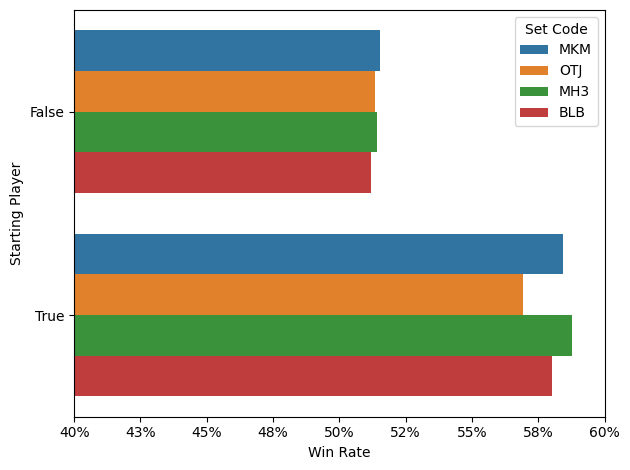

In [6]:
# | label: fig-starting-win-rate
# | fig-cap: "The win rate for starting versus non-starting player."


g = sns.barplot(
    data=starting,
    x="win_rate",
    y="on_play",
    hue="expansion",
    hue_order=set_codes_order,
    orient="h",
)
plt.gca().set(xlim=(0.40, 0.60))
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(
    xlabel="Win Rate",
    ylabel="Starting Player",
    legend=True,
    legend_title="Set Code",
)

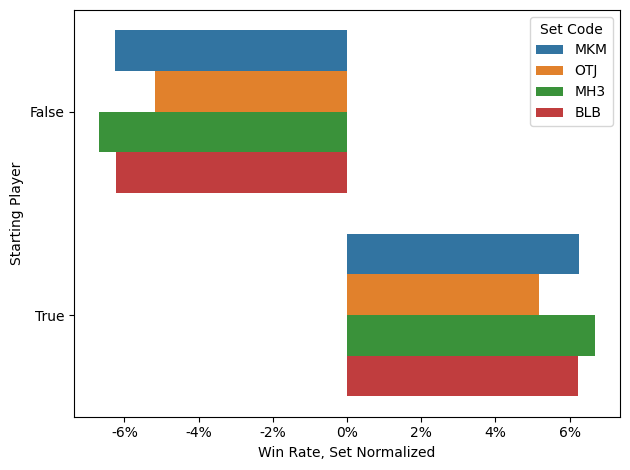

In [7]:
# | label: fig-starting-win-rate
# | fig-cap: "The win rate for starting versus non-starting player."


g = sns.barplot(
    data=starting,
    x="normalized_win_rate",
    y="on_play",
    hue="expansion",
    hue_order=set_codes_order,
    orient="h",
)
# plt.gca().set(xlim=(0.90, 1.10))
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(
    xlabel="Win Rate, Set Normalized",
    ylabel="Starting Player",
    legend=True,
    legend_title="Set Code",
)